# Fuzzing with Derivation Trees

In the chapter on ["Grammars"](Grammars.ipynb), we have introduced the concept of _grammars_ that specify input formats and _producers_ that randomly pgenerate a valid input from a grammar.  In this chapter, we take this idea one step further: By introducing _derivation trees_ that encode a (produced) string as a syntactic structure, we allow for easy manipulation of inputs produced from grammars.

**Prerequisites**

* You should know how grammar-based fuzzing works, e.g. from the ["Grammars" chapter](Grammars.ipynb).

## Representing Derivation

e.g. `<expr> + <expr>`

In [242]:
import gstbook

In [243]:
import re
import random

In [244]:
from Grammars import START_SYMBOL, RE_SYMBOL, EXPR_GRAMMAR, symbols

In [245]:
derivation_tree = ("<start>", 
        [("<expr>", 
          [("<expr>", None),
           (" + ", []),
           ("<expr>", None)]
         )])

Let's visualize this tree!

In [246]:
from pydot import Dot, Edge, Node
from IPython.display import Image, display

In [247]:
def display_tree(derivation_tree):
    """Visualize a derivation tree using dot layout."""
    counter = 0

    def unique_id():
        nonlocal counter
        counter += 1
        return counter
    
    def node(id, symbol):
        lbl = symbol.replace("\\", "\\\\").replace("<", "\\<").replace(">", "\\>")
        return Node(id, label=lbl, shape="plain")
    
    def traverse_tree(tree, graph, id=unique_id()):
        (symbol, children) = tree
        symbol_node = node(id, symbol)
        graph.add_node(symbol_node)
        if children is not None:
            for child in children:
                (child_symbol, _) = child
                child_id = unique_id()
                child_node = node(child_id, child_symbol)
                graph.add_edge(Edge(symbol_node, child_node))
                traverse_tree(child, graph, child_id)

    graph = Dot(graph_type="digraph")
    traverse_tree(derivation_tree, graph)
    display(Image(graph.create_png()))

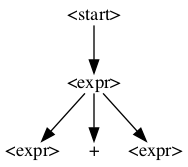

In [248]:
display_tree(derivation_tree)

## Expanding a Node

In [249]:
def init_tree(start_symbol=START_SYMBOL):
    return (start_symbol, None)

In [250]:
def is_symbol(s):
    return re.match(RE_SYMBOL, s)

In [251]:
assert is_symbol("<abc>")
assert not is_symbol("+")

In [252]:
def expansion_to_children(expansion):
    # print("Converting " + repr(expansion))
    # strings contains all substrings -- both terminals and non-terminals such
    # that ''.join(strings) == expansion
    strings  = re.split(RE_SYMBOL, expansion)
    return [(s, None) if is_symbol(s) else (s, []) for s in strings if len(s) > 0]

In [253]:
expansion_to_children("<term> + <expr>")

[('<term>', None), (' + ', []), ('<expr>', None)]

In [254]:
def expand_random_node(node, grammar):
    (symbol, children) = node
    assert children is None

    # Fetch the possible expansions from grammar...
    expansions = grammar[symbol]

    possible_children = [expansion_to_children(expansion) for expansion in expansions]

    # TODO: Consider preferring children not expanded yet,
    # and other forms of grammar coverage (or code coverage)
    children = random.choice(possible_children)

    # Return with a new list
    return (symbol, children)

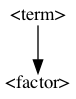

In [255]:
example_node = ("<term>", None)
example_tree = expand_random_node(example_node, EXPR_GRAMMAR)
display_tree(example_tree)

## Expanding a Tree

In [256]:
def possible_expansions(tree):
    (symbol, children) = tree
    if children is None:
        return 1

    number_of_expansions = sum(possible_expansions(c) for c in children)
    return number_of_expansions

In [257]:
possible_expansions(example_tree)

1

In [258]:
def any_possible_expansions(tree):
    (symbol, children) = tree
    if children is None: return True

    return any(any_possible_expansions(c) for c in children)

In [259]:
any_possible_expansions(example_tree)

True

In [260]:
def expand_tree_once(tree, grammar, expand_node=expand_random_node):
    (symbol, children) = tree
    if children is None:
        # Expand this node
        return expand_node(tree, grammar)

    # print("Expanding tree " + repr(tree))

    # Find all children with possible expansions
    expandable_children = [i for (i, c) in enumerate(children) if any_possible_expansions(c)]

    # Select a random child
    # TODO: Various heuristics for choosing a child here,
    # e.g. grammar or code coverage
    child_to_be_expanded = random.choice(expandable_children)

    # Expand it
    new_child = expand_tree_once(children[child_to_be_expanded], grammar, expand_node)

    new_children = (children[:child_to_be_expanded] +
                    [new_child] +
                    children[child_to_be_expanded + 1:])

    new_tree = (symbol, new_children)

    # print("Expanding tree " + repr(tree) + " into " + repr(new_tree))

    return new_tree

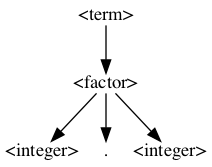

In [261]:
example_tree_expanded = expand_tree_once(example_tree, EXPR_GRAMMAR)
display_tree(example_tree_expanded)

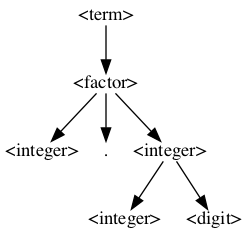

In [262]:
example_tree_expanded_twice = expand_tree_once(example_tree_expanded, EXPR_GRAMMAR)
display_tree(example_tree_expanded_twice)

## Closing the Expansion

In [263]:
def symbol_min_cost(symbol, grammar, seen=set()):
    expansions = grammar[symbol]
    return min(min_expansions(e, grammar, seen | {symbol}) for e in expansions)

In [264]:
def min_expansions(expansion, grammar, seen=set()):
    syms = symbols(expansion)
    # at least one expansion has no variable to expand.
    if len(syms) == 0:
        return 1

    # if a variable present in the expansion is already in the stack, then it is
    # recursion
    if any(s in seen for s in syms):
        return float('inf')

    # the value of a expansion is the sum of all expandable variables inside + 1
    return sum(symbol_min_cost(s, grammar, seen) for s in syms) + 1

In [265]:
symbol_min_cost("<digit>", EXPR_GRAMMAR)

1

In [266]:
for expansion in EXPR_GRAMMAR["<expr>"]:
    m = min_expansions(expansion, EXPR_GRAMMAR, seen={"<expr>"})
    print(repr(expansion), "has cost", m)

'<expr> + <term>' has cost inf
'<expr> - <term>' has cost inf
'<term>' has cost 5


In [267]:
symbol_min_cost("<expr>", EXPR_GRAMMAR)

5

In [268]:
def expand_min_expansions(node, grammar):
    (symbol, children) = node
    # print("Expanding " + repr(symbol))
    assert children is None

    # Fetch the possible expansions from grammar...
    expansions = grammar[symbol]

    possible_children_with_cost = [(expansion_to_children(expansion),
                                    min_expansions(expansion, grammar, {symbol}))
                                  for expansion in expansions]

    min_cost = min(cost for (child, cost) in possible_children_with_cost)
    children_with_min_cost = [child for (child, child_cost) in possible_children_with_cost
                              if child_cost == min_cost]

    children = random.choice(children_with_min_cost)

    # Return with a new list
    return (symbol, children)

## All Together

In [293]:
def expand_tree(tree, grammar, max_symbols=10, disp=False, log=False):
    
    def _expand_tree_once(tree, grammar, expand_node, disp, log):
        tree = expand_tree_once(tree, grammar, expand_node)
        if disp:
            display_tree(tree)
            print(possible_expansions(tree), "possible expansion(s) left")
        if log:
            print(tree)
        return tree

    if disp or log:
        print("Stage 1: Expanding until we reach", max_symbols, "unexpanded symbols")

    while 0 < possible_expansions(tree) < max_symbols:
        tree = _expand_tree_once(tree, grammar, expand_random_node, disp, log)

    if disp or log:
        print("Stage 2: Keep on expanding using shortest expansions only")

    while any_possible_expansions(tree):
        tree = _expand_tree_once(tree, grammar, expand_min_expansions, disp, log)

    return tree

Stage 1: Expanding until we reach 5 unexpanded symbols


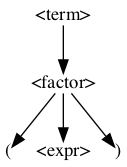

1 possible expansion(s) left


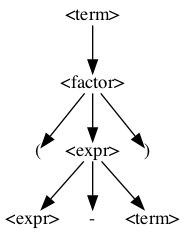

2 possible expansion(s) left


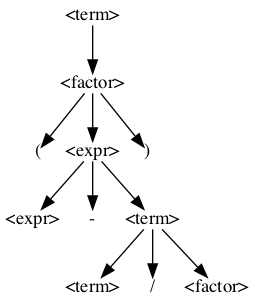

3 possible expansion(s) left


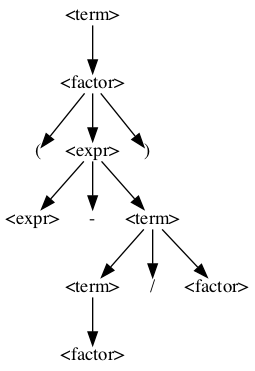

3 possible expansion(s) left


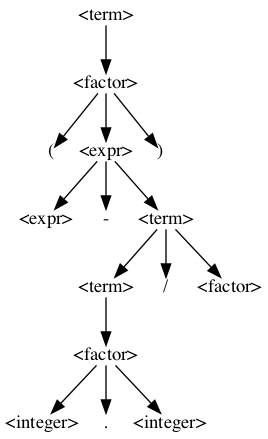

4 possible expansion(s) left


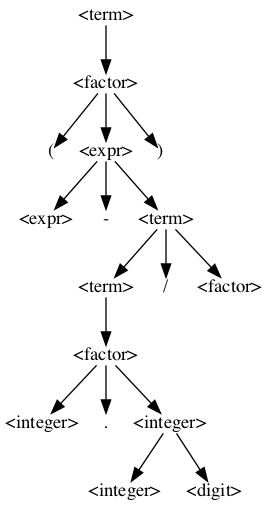

5 possible expansion(s) left
Stage 2: Keep on expanding using shortest expansions only


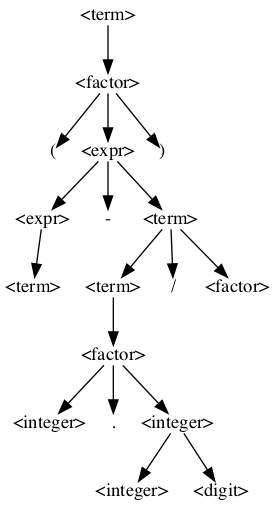

5 possible expansion(s) left


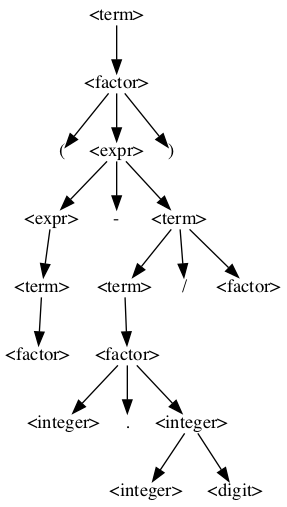

5 possible expansion(s) left


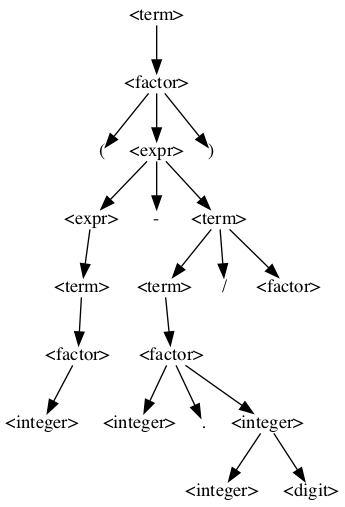

5 possible expansion(s) left


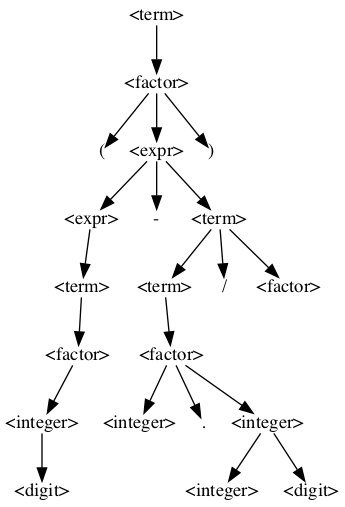

5 possible expansion(s) left


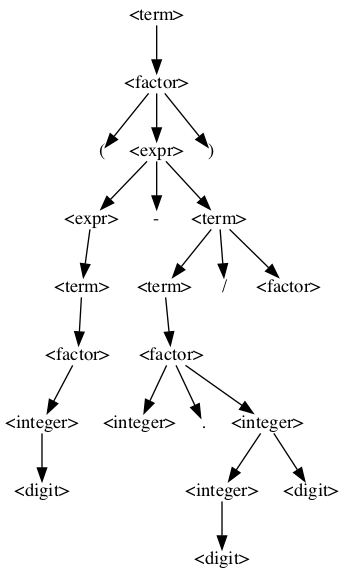

5 possible expansion(s) left


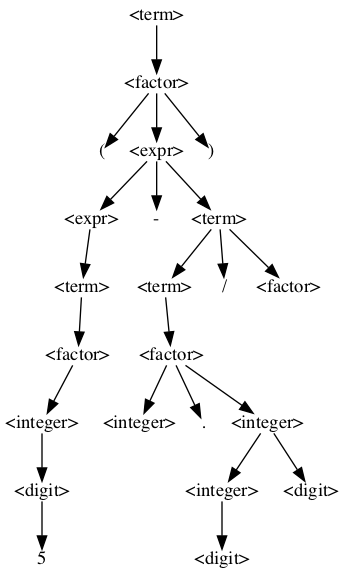

4 possible expansion(s) left


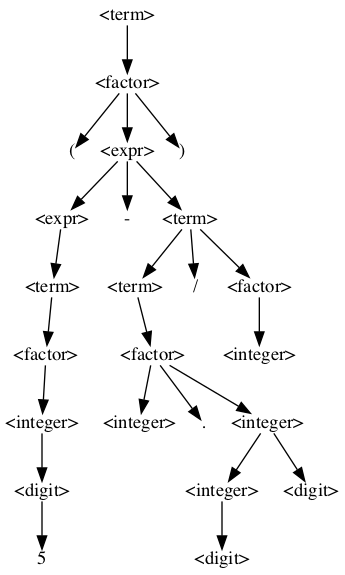

4 possible expansion(s) left


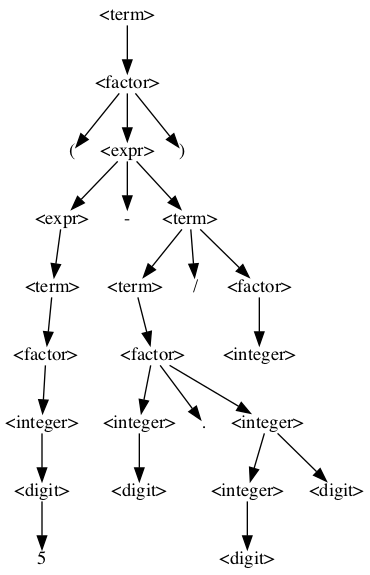

In [ ]:
expanded_tree = expand_tree(example_tree, EXPR_GRAMMAR, max_symbols=5, disp=True)
print("Final tree")
display_tree(expanded_tree)

In [271]:
def all_terminals(tree):
    (symbol, children) = tree
    if children is None:
        # This is a nonterminal symbol not expanded yet
        return symbol

    if len(children) == 0:
        # This is a terminal symbol
        return symbol

    # This is an expanded symbol:
    # Concatenate all terminal symbols from all children
    return ''.join([all_terminals(c) for c in children])

In [272]:
all_terminals(expanded_tree)

'29.924'

In [273]:
def produce(grammar, max_symbols=10, start_symbol=START_SYMBOL, disp=False, log=False):
    # Create an initial derivation tree
    tree = init_tree(start_symbol)
    # print(tree)

    # Expand all nonterminals
    tree = expand_tree(tree, grammar, max_symbols)
    if disp:
        display_tree(tree)
    if log:
        print(tree)

    # Return the string
    return all_terminals(tree)

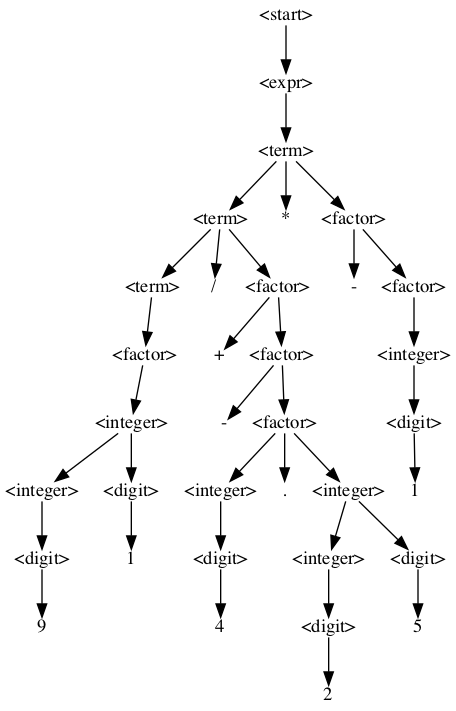

91 / +-4.25 * -1


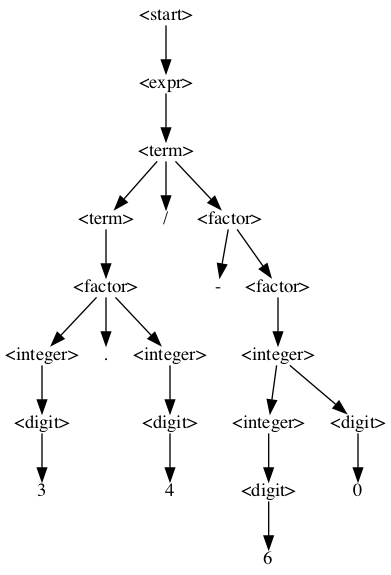

3.4 / -60


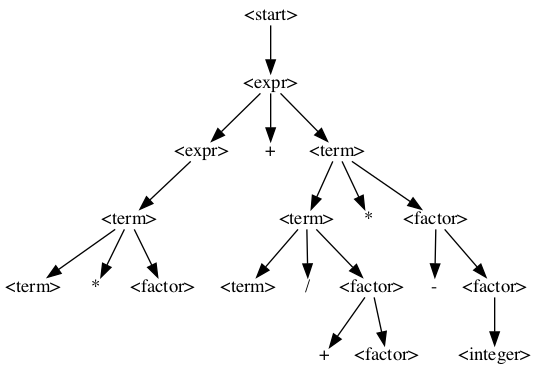

<term> * <factor> + <term> / +<factor> * -<integer>


In [274]:
for i in range(3):
    print(produce(EXPR_GRAMMAR, max_symbols=5, disp=True))

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](Mutation_Fuzzing.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducing.ipynb)


## Exercises

_Close the chapter with a few exercises such that people have things to do.  Use the Jupyter `Exercise2` nbextension to add solutions that can be interactively viewed or hidden.  (Alternatively, just copy the exercise and solution cells below with their metadata.)  We will set up things such that solutions do not appear in the PDF and HTML formats._

### Exercise 1


_Solution for the exercise_